# Heart Disease Classification

<b>Dataset Used: Heart Disease Dataset</b> (https://archive.ics.uci.edu/dataset/45/heart+disease)

<b>Description of attributes</b>
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptom
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' crite
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downslop
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num (<b>Target</b>): diagnosis of heart disease (angiographic disease status) 
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowingingriaatic

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from decision_tree import *
from NN_framework import NeuralNet
from sklearn import metrics
import seaborn as sns

In [2]:
THRESH = 0.5

## Loading the Dataset

In [3]:
file = 'datasets/heart.csv'
df = pd.read_csv(file)
X_raw = np.genfromtxt(file, delimiter=',', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12), skip_header=1)
y = np.genfromtxt(file, delimiter=',', usecols=13, skip_header=1)

print(f"X_raw shape: {X_raw.shape}")
print(f"y shape: {y.shape}")

X_raw shape: (1025, 13)
y shape: (1025,)


In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1
1024,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


In [6]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.43,9.07,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.70,0.46,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.94,1.03,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.61,17.52,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.00,51.59,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.15,0.36,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.53,0.53,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.11,23.01,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.34,0.47,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.07,1.18,0.0,0.0,0.8,1.8,6.2


In [7]:
df['target'].value_counts()

target
1    526
0    499
Name: count, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

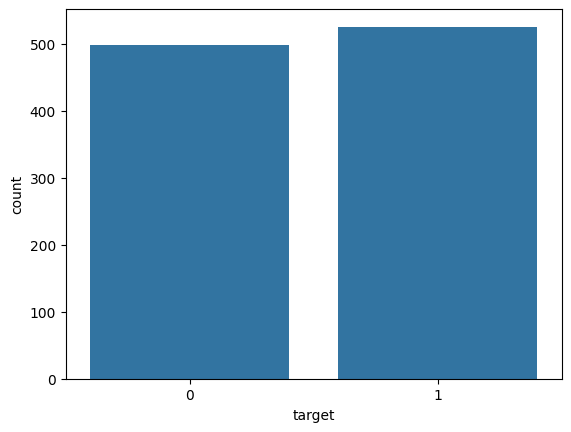

In [8]:
sns.countplot(x = 'target', data = df)

<AxesSubplot:>

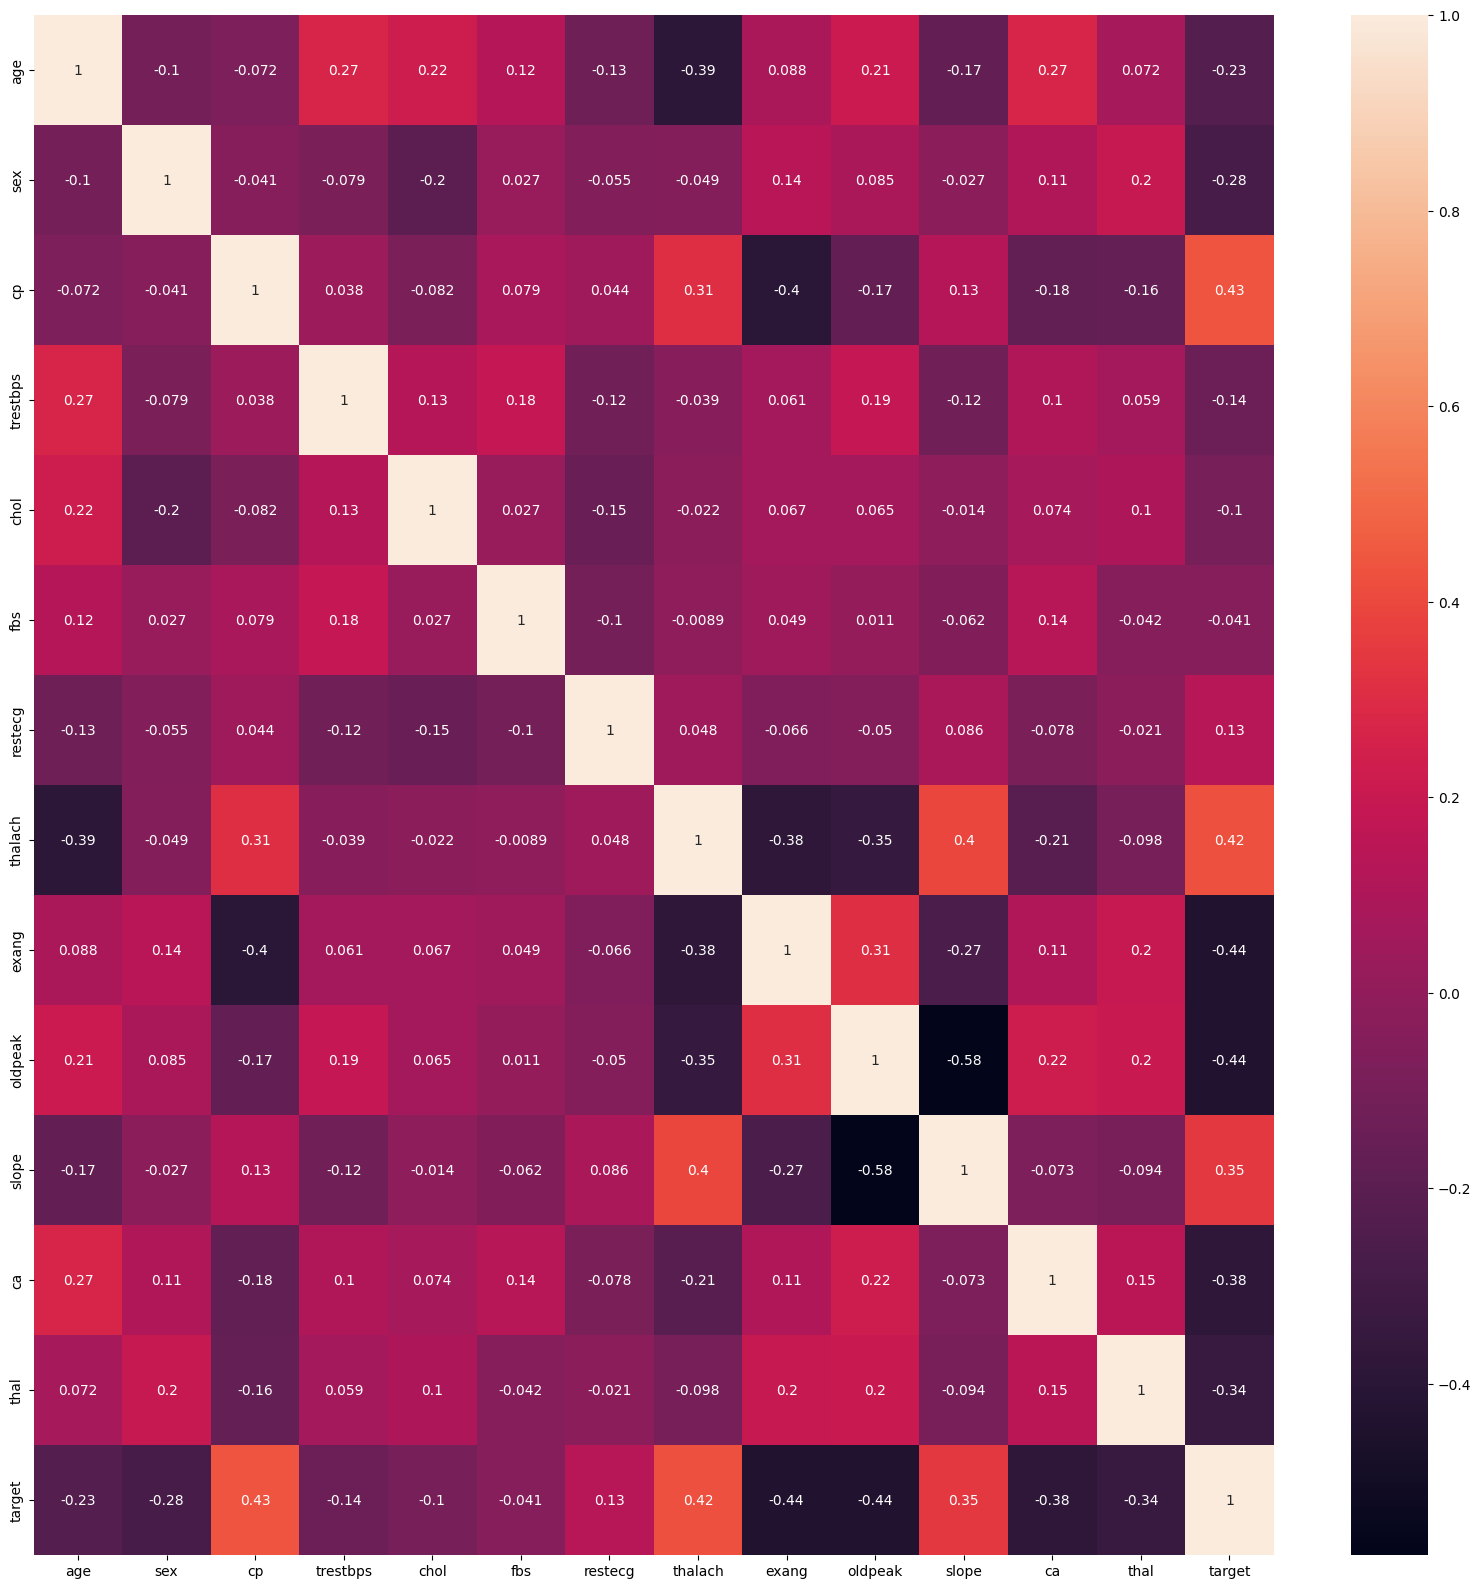

In [9]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

We have to one-hot encode the categorical attributes 3, 7, 11, 12, 13 as they have more than two distinct values.

In [10]:
def one_hot_encode(X, attributes):
    attributes = np.array(attributes)-1
    new_num_att = 0
    for i in range(X.shape[1]):
        if i in attributes: new_num_att += len(np.unique(X[:, i]))
        else: new_num_att += 1

    X_new = np.zeros((X.shape[0], new_num_att))
    at_col = 0
    for i in range(X.shape[1]):
        if i in attributes:
            unique_val = np.unique(X[:, i])
            for j in range(len(unique_val)):
                X_new[:, at_col] = (X[:, i] == unique_val[j]).astype(float)
                at_col += 1
        else:
            X_new[:, at_col] = X[:, i]
            at_col += 1
    return X_new

In [11]:
X = one_hot_encode(X_raw, [3, 7, 11, 12, 13])

print(f"X shape: {X.shape}")

X shape: (1025, 27)


### Train and Cross-validation split

In [12]:
def split_data(X, y, ratio):
    m = X.shape[0]
    randix = np.random.permutation(m)
    
    m_cv = (m*ratio[1])//100
    m_test = (m*ratio[2])//100

    at_index = 0

    X_cv = X[randix[0: m_cv]]
    y_cv = y[randix[0: m_cv]]
    X_test = X[randix[m_cv: m_test+m_cv]]
    y_test = y[randix[m_cv: m_test+m_cv]]
    X_train = X[randix[m_test+m_cv: ]]
    y_train = y[randix[m_test+m_cv: ]]

    return X_train, y_train, X_cv, y_cv, X_test, y_test 

In [93]:
X_train, y_train, X_cv, y_cv, _, _ = split_data(X, y, (80, 20, 0))

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"Train set info--> 1: {np.count_nonzero(y_train==1)} | 0: {np.count_nonzero(y_train==0)}")
print(f"\n")
print(f"X_cv.shape: {X_cv.shape}")
print(f"y_cv.shape: {y_cv.shape}")
print(f"CV set info--> 1: {np.count_nonzero(y_cv==1)} | 0: {np.count_nonzero(y_cv==0)}")

X_train.shape: (820, 27)
y_train.shape: (820,)
Train set info--> 1: 414 | 0: 406


X_cv.shape: (205, 27)
y_cv.shape: (205,)
CV set info--> 1: 112 | 0: 93


In [14]:
def evaluate_model_performance(y, y_pred, print_opt=True):
    confusion_matrix = metrics.confusion_matrix(y, y_pred)
    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    F1_score = metrics.f1_score(y, y_pred)

    if print_opt:
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision} | Recall: {recall}")
        print(f"F1 Score: {F1_score}")
    return confusion_matrix, accuracy, precision, recall, F1_score

## Logistic Regression
Logistic regression can be achieved by building a neural network with a single layer having sigmoid activation.

<b>Normalising the data (only the continuous attributes)</b>

In [94]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

In [16]:
def normalise(X, mean, std):
    X_norm = (X-mean)/std
    for i in range(X.shape[1]):
        if len(np.unique(X[:, i])) == 2 and all(np.unique(X[:, i]) == np.array([0,1])):
            X_norm[:, i] = X[:, i]
    return X_norm

In [95]:
X_train_norm = normalise(X_train, mean, std)
X_cv_norm = normalise(X_cv, mean, std)

In [96]:
LR = NeuralNet(X_train_norm.T, y_train.reshape(1, (len(y_train))), nodes=[1], activations=['sigmoid'], task='binary')

W1 shape: (1, 27)
b1 shape: (1, 1)
Total Parameters: 28


In [97]:
LR.train(epochs=1000, batch_size=-1, alpha=0.01)

At epoch 0 --> Accuracy: 64.39 | Cost: 0.6891708975567875
At epoch 100 --> Accuracy: 87.683 | Cost: 0.3209780471294132
At epoch 200 --> Accuracy: 87.561 | Cost: 0.2986970141874769
At epoch 300 --> Accuracy: 87.561 | Cost: 0.29189296451552654
At epoch 400 --> Accuracy: 87.439 | Cost: 0.2890710924627323
At epoch 500 --> Accuracy: 87.805 | Cost: 0.28783987171694814
At epoch 600 --> Accuracy: 87.805 | Cost: 0.2873225602163228
At epoch 700 --> Accuracy: 87.805 | Cost: 0.2871201773622133
At epoch 800 --> Accuracy: 87.805 | Cost: 0.28704753668977406
At epoch 900 --> Accuracy: 87.805 | Cost: 0.2870238479342737
At epoch 1000 --> Accuracy: 87.805 | Cost: 0.28701688826093863


In [98]:
LR_train_pred = (LR.forward_pass(LR.trained_param, X_train_norm.T) > THRESH).astype(int).reshape(X_train_norm.shape[0])

In [99]:
LR_cv_pred = (LR.forward_pass(LR.trained_param, X_cv_norm.T) > THRESH).astype(int).reshape(X_cv_norm.shape[0])

In [100]:
#Performace on the training set
_, _, _, _, _ = evaluate_model_performance(y_train, LR_train_pred)

Accuracy: 0.8780487804878049
Precision: 0.8552036199095022 | Recall: 0.9130434782608695
F1 Score: 0.8831775700934579


In [101]:
#Performace on the cross-validation set
LR_confusion_matrix, LR_accuracy, LR_precision, LR_recall, LR_F1_score = evaluate_model_performance(y_cv, LR_cv_pred)

Accuracy: 0.8682926829268293
Precision: 0.8695652173913043 | Recall: 0.8928571428571429
F1 Score: 0.8810572687224669


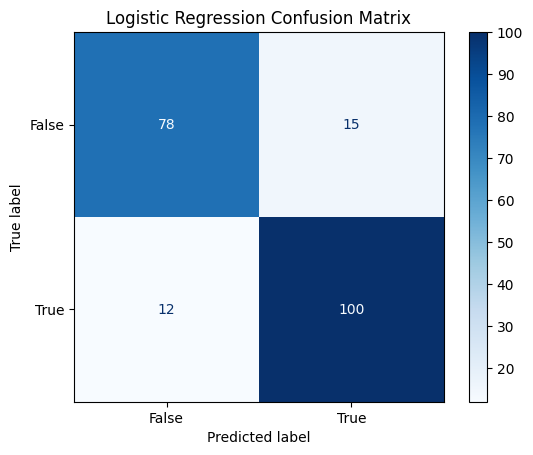

In [102]:
LR_cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = LR_confusion_matrix, display_labels = [False, True])
LR_cm_plot.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

## Artificial Neural Network

In [109]:
ANN = NeuralNet(X_train_norm.T, y_train.reshape(1, (len(y_train))), nodes=[25, 15, 1], 
                activations=['relu', 'relu', 'sigmoid'], task='binary')

W1 shape: (25, 27)
b1 shape: (25, 1)
W2 shape: (15, 25)
b2 shape: (15, 1)
W3 shape: (1, 15)
b3 shape: (1, 1)
Total Parameters: 1106


In [240]:
ANN.train(epochs=2000, batch_size=-1, alpha=0.01, lambd=4)

At epoch 0 --> Accuracy: 50.732 | Cost: 0.6933944890482161
At epoch 200 --> Accuracy: 97.805 | Cost: 0.1882982275784939
At epoch 400 --> Accuracy: 99.39 | Cost: 0.14681824867807863
At epoch 600 --> Accuracy: 99.39 | Cost: 0.14455743632010043
At epoch 800 --> Accuracy: 99.39 | Cost: 0.144004953595418
At epoch 1000 --> Accuracy: 99.39 | Cost: 0.14327159820360152
At epoch 1200 --> Accuracy: 100.0 | Cost: 0.13982861953485493
At epoch 1400 --> Accuracy: 100.0 | Cost: 0.13985498300430405
At epoch 1600 --> Accuracy: 100.0 | Cost: 0.1394404479827155
At epoch 1800 --> Accuracy: 99.756 | Cost: 0.1397315294490985
At epoch 2000 --> Accuracy: 100.0 | Cost: 0.13948813122900222


In [111]:
ANN_train_pred = (ANN.forward_pass(ANN.trained_param, X_train_norm.T) > THRESH).astype(int).reshape(X_train_norm.shape[0])

In [112]:
ANN_cv_pred = (ANN.forward_pass(ANN.trained_param, X_cv_norm.T) > THRESH).astype(int).reshape(X_cv_norm.shape[0])

In [113]:
#Performance on the training set
_, _, _, _, _ = evaluate_model_performance(y_train, ANN_train_pred)

Accuracy: 1.0
Precision: 1.0 | Recall: 1.0
F1 Score: 1.0


In [114]:
#Performance on the cross-validation set
ANN_confusion_matrix, ANN_accuracy, ANN_precision, ANN_recall, ANN_F1_score = evaluate_model_performance(y_cv, ANN_cv_pred)

Accuracy: 1.0
Precision: 1.0 | Recall: 1.0
F1 Score: 1.0


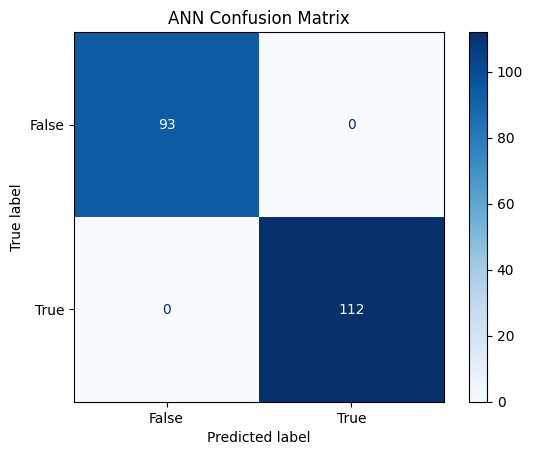

In [115]:
ANN_cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = ANN_confusion_matrix, display_labels = [False, True])
ANN_cm_plot.plot(cmap='Blues')
plt.title('ANN Confusion Matrix')
plt.show()

<b>Wow!</b>

## DecisionTree

In [116]:
DT = DecisionTree(X_train, y_train, task='classification')

In [137]:
DT.build_tree(max_depth=11) #constraints added to prevent over-fitting

 Depth 0,Root: Split on feature: 2
- Depth 1,Left: Split on feature: 18
-- Depth 2,Left: Split on feature: 26
--- Depth 3,Left: Split on feature: 14
---- Depth 4,Left: Split on feature: 0
     ----- Depth 5, Left leaf with indices [  8 124 187 288 332 596 710 751]
----- Depth 5,Right: Split on feature: 7
      ------ Depth 6, Left leaf with indices [123 172 242 253 323 342 354 407 565 658 761 782]
      ------ Depth 6, Right leaf with indices [210 295 515]
    ---- Depth 4, Right leaf with indices [ 24  60  68  74  77  79  84 117 129 157 204 217 234 240 259 264 278 293
 307 317 326 346 394 401 429 430 462 468 469 471 477 497 506 518 520 530
 547 556 562 603 622 623 646 651 667 684 702 711 717 719 734 763 776 783
 789]
--- Depth 3,Right: Split on feature: 12
    ---- Depth 4, Left leaf with indices [ 46 228 294 572 616 704 815]
---- Depth 4,Right: Split on feature: 13
----- Depth 5,Left: Split on feature: 9
      ------ Depth 6, Left leaf with indices [ 31  81 128 137 368 461 466 585 63

In [138]:
DT_train_pred = DT.run_inference(X_train, DT.tree)

In [139]:
#Performance on the training set
_, _, _, _, _ = evaluate_model_performance(y_train, DT_train_pred)

Accuracy: 0.9963414634146341
Precision: 0.9928057553956835 | Recall: 1.0
F1 Score: 0.996389891696751


In [140]:
DT_cv_pred = DT.run_inference(X_cv, DT.tree)

In [141]:
#Performance on the cross-validation set
DT_confusion_matrix, DT_accuracy, DT_precision, DT_recall, DT_F1_score = evaluate_model_performance(y_cv, DT_cv_pred)

Accuracy: 0.9951219512195122
Precision: 0.9911504424778761 | Recall: 1.0
F1 Score: 0.9955555555555555


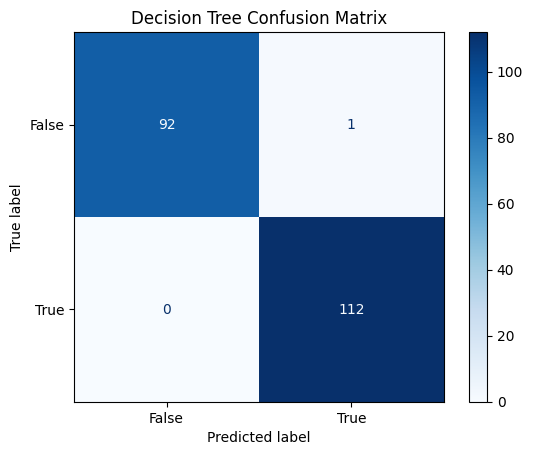

In [142]:
DT_cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = DT_confusion_matrix, display_labels = [False, True])
DT_cm_plot.plot(cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

<b>Much better than expected!</b>

## Bagging

Bagging is achieved by considering all the features at every split. This is done by setting the <i>num_features</i> parameter to 'all'.

In [143]:
BC = RandomForest(X_train, y_train, 'classification')

In [144]:
BC.build_ensemble(num_trees=200, max_depth=10, num_features='all')

Building Tree 1.......
Building Tree 2.......
Building Tree 3.......
Building Tree 4.......
Building Tree 5.......
Building Tree 6.......
Building Tree 7.......
Building Tree 8.......
Building Tree 9.......
Building Tree 10.......
Building Tree 11.......
Building Tree 12.......
Building Tree 13.......
Building Tree 14.......
Building Tree 15.......
Building Tree 16.......
Building Tree 17.......
Building Tree 18.......
Building Tree 19.......
Building Tree 20.......
Building Tree 21.......
Building Tree 22.......
Building Tree 23.......
Building Tree 24.......
Building Tree 25.......
Building Tree 26.......
Building Tree 27.......
Building Tree 28.......
Building Tree 29.......
Building Tree 30.......
Building Tree 31.......
Building Tree 32.......
Building Tree 33.......
Building Tree 34.......
Building Tree 35.......
Building Tree 36.......
Building Tree 37.......
Building Tree 38.......
Building Tree 39.......
Building Tree 40.......
Building Tree 41.......
Building Tree 42.......
B

In [145]:
BC_train_pred = BC.run_inference_on_ensemble(X_train, BC.ensemble)

In [146]:
#Performance on the training set
_, _, _, _, _ = evaluate_model_performance(y_train, BC_train_pred)

Accuracy: 1.0
Precision: 1.0 | Recall: 1.0
F1 Score: 1.0


In [147]:
BC_cv_pred = BC.run_inference_on_ensemble(X_cv, BC.ensemble)

In [148]:
#Performance on the cross-validation set
BC_confusion_matrix, BC_accuracy, BC_precision, BC_recall, BC_F1_score = evaluate_model_performance(y_cv, BC_cv_pred)

Accuracy: 1.0
Precision: 1.0 | Recall: 1.0
F1 Score: 1.0


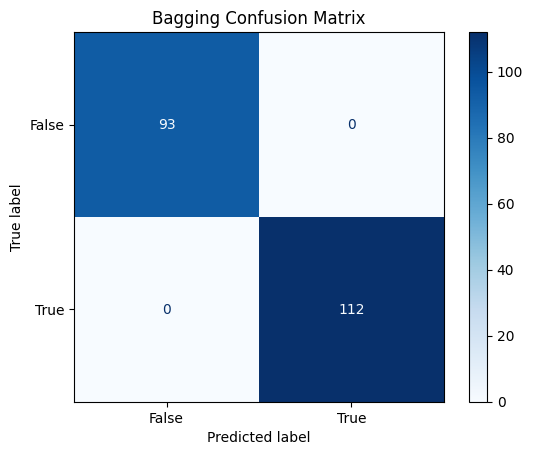

In [149]:
BC_cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = BC_confusion_matrix, display_labels = [False, True])
BC_cm_plot.plot(cmap='Blues')
plt.title('Bagging Confusion Matrix')
plt.show()

## Random Forest

In [150]:
RF = RandomForest(X_train, y_train, 'classification')

In [162]:
RF.build_ensemble(num_trees=200, max_depth=10, num_features=6) 

Building Tree 1.......
Building Tree 2.......
Building Tree 3.......
Building Tree 4.......
Building Tree 5.......
Building Tree 6.......
Building Tree 7.......
Building Tree 8.......
Building Tree 9.......
Building Tree 10.......
Building Tree 11.......
Building Tree 12.......
Building Tree 13.......
Building Tree 14.......
Building Tree 15.......
Building Tree 16.......
Building Tree 17.......
Building Tree 18.......
Building Tree 19.......
Building Tree 20.......
Building Tree 21.......
Building Tree 22.......
Building Tree 23.......
Building Tree 24.......
Building Tree 25.......
Building Tree 26.......
Building Tree 27.......
Building Tree 28.......
Building Tree 29.......
Building Tree 30.......
Building Tree 31.......
Building Tree 32.......
Building Tree 33.......
Building Tree 34.......
Building Tree 35.......
Building Tree 36.......
Building Tree 37.......
Building Tree 38.......
Building Tree 39.......
Building Tree 40.......
Building Tree 41.......
Building Tree 42.......
B

In [163]:
RF_train_pred = RF.run_inference_on_ensemble(X_train, RF.ensemble)

In [164]:
#Performance on the training set
_, _, _, _, _ = evaluate_model_performance(y_train, RF_train_pred)

Accuracy: 1.0
Precision: 1.0 | Recall: 1.0
F1 Score: 1.0


In [165]:
RF_cv_pred = RF.run_inference_on_ensemble(X_cv, RF.ensemble)

In [166]:
#Performance on the cross-validation set
RF_confusion_matrix, RF_accuracy, RF_precision, RF_recall, RF_F1_score = evaluate_model_performance(y_cv, RF_cv_pred)

Accuracy: 1.0
Precision: 1.0 | Recall: 1.0
F1 Score: 1.0


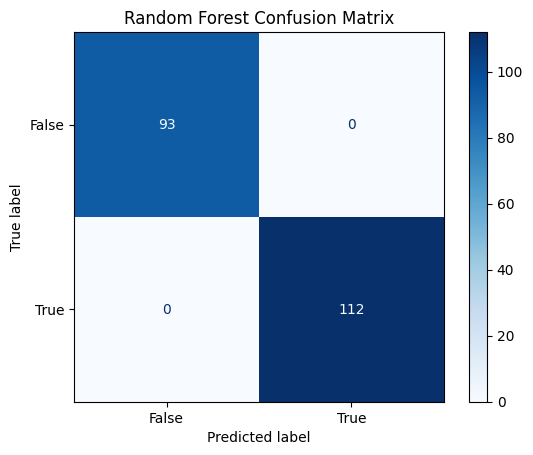

In [167]:
RF_cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = RF_confusion_matrix, display_labels = [False, True])
RF_cm_plot.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

## Adaboost

In [168]:
ABC = AdaBoostClassifier(X_train, y_train)

In [196]:
ABC.train(n_learners=20, depth=1, store_error=True, X_cv=X_cv, y_cv=y_cv)

Building learner: 1....
Building learner: 2....
Building learner: 3....
Building learner: 4....
Building learner: 5....
Building learner: 6....
Building learner: 7....
Building learner: 8....
Building learner: 9....
Building learner: 10....
Building learner: 11....
Building learner: 12....
Building learner: 13....
Building learner: 14....
Building learner: 15....
Building learner: 16....
Building learner: 17....
Building learner: 18....
Building learner: 19....
Building learner: 20....


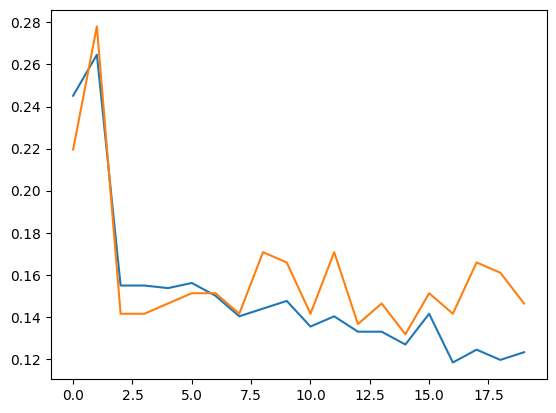

In [197]:
plt.plot(ABC.train_error_hist)
plt.plot(ABC.cv_error_hist)

In [198]:
ABC_train_pred = ABC.predict(X_train, ABC.learners)

In [199]:
#Performance on the training set
_, _, _, _, _ = evaluate_model_performance(y_train, ABC_train_pred)

Accuracy: 0.8768292682926829
Precision: 0.8597701149425288 | Recall: 0.9033816425120773
F1 Score: 0.8810365135453475


In [200]:
ABC_cv_pred = ABC.predict(X_cv, ABC.learners)

In [201]:
#Performance on the cross-validation set
ABC_confusion_matrix, ABC_accuracy, ABC_precision, ABC_recall, ABC_F1_score = evaluate_model_performance(y_cv, ABC_cv_pred)

Accuracy: 0.8536585365853658
Precision: 0.847457627118644 | Recall: 0.8928571428571429
F1 Score: 0.8695652173913044


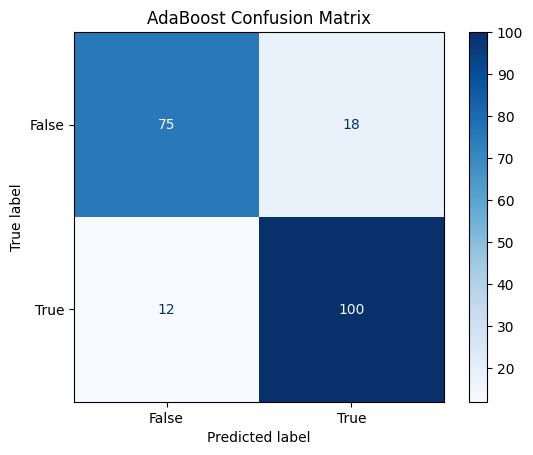

In [202]:
ABC_cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = ABC_confusion_matrix, display_labels = [False, True])
ABC_cm_plot.plot(cmap='Blues')
plt.title('AdaBoost Confusion Matrix')
plt.show()

<b>AdaBoost has a pretty bad performance!</b>

## GradientBoost

In [203]:
GBC = GradientBoostClassifier(X_train, y_train)

In [229]:
GBC.train(learning_rate=0.1, n_trees=200, max_depth=10, store_hist=True, X_cv=X_cv, y_cv=y_cv)

Buidling tree: 1....
Buidling tree: 2....
Buidling tree: 3....
Buidling tree: 4....
Buidling tree: 5....
Buidling tree: 6....
Buidling tree: 7....
Buidling tree: 8....
Buidling tree: 9....
Buidling tree: 10....
Buidling tree: 11....
Buidling tree: 12....
Buidling tree: 13....
Buidling tree: 14....
Buidling tree: 15....
Buidling tree: 16....
Buidling tree: 17....
Buidling tree: 18....
Buidling tree: 19....
Buidling tree: 20....
Buidling tree: 21....
Buidling tree: 22....
Buidling tree: 23....
Buidling tree: 24....
Buidling tree: 25....
Buidling tree: 26....
Buidling tree: 27....
Buidling tree: 28....
Buidling tree: 29....
Buidling tree: 30....
Buidling tree: 31....
Buidling tree: 32....
Buidling tree: 33....
Buidling tree: 34....
Buidling tree: 35....
Buidling tree: 36....
Buidling tree: 37....
Buidling tree: 38....
Buidling tree: 39....
Buidling tree: 40....
Buidling tree: 41....
Buidling tree: 42....
Buidling tree: 43....
Buidling tree: 44....
Buidling tree: 45....
Buidling tree: 46..

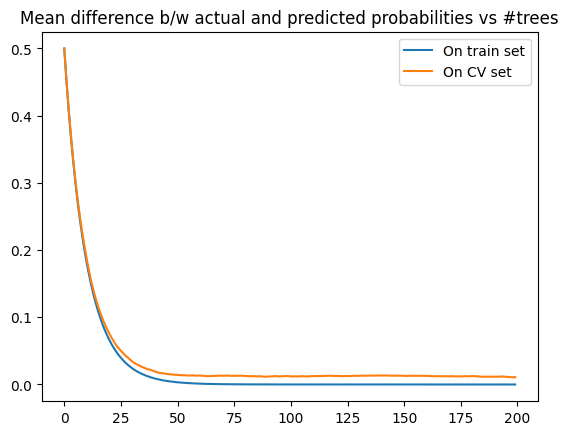

In [230]:
plt.plot(GBC.train_error_hist, label='On train set')
plt.plot(GBC.cv_error_hist, label='On CV set')
plt.title("Mean difference b/w actual and predicted probabilities vs #trees")
plt.legend()

In [231]:
GBC_train_pred = GBC.predict(X_train, GBC.trees, enable_thresh=True)

In [232]:
#Performance on the training set
_, _, _, _, _ = evaluate_model_performance(y_train, GBC_train_pred)

Accuracy: 1.0
Precision: 1.0 | Recall: 1.0
F1 Score: 1.0


In [233]:
GBC_cv_pred = GBC.predict(X_cv, GBC.trees, enable_thresh=True)

In [234]:
#Performance on the cross-validation set
GBC_confusion_matrix, GBC_accuracy, GBC_precision, GBC_recall, GBC_F1_score = evaluate_model_performance(y_cv, GBC_cv_pred)

Accuracy: 0.9853658536585366
Precision: 1.0 | Recall: 0.9732142857142857
F1 Score: 0.9864253393665159


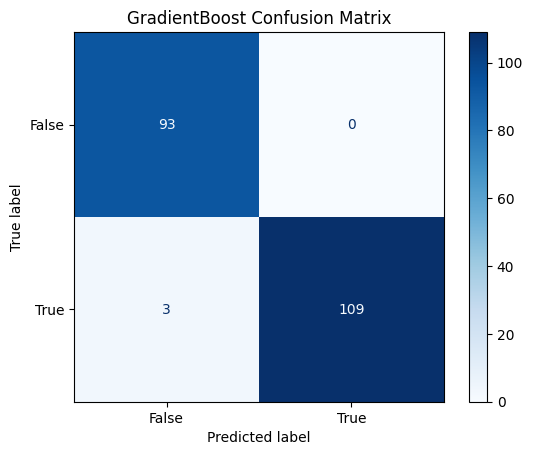

In [235]:
GBC_cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = GBC_confusion_matrix, display_labels = [False, True])
GBC_cm_plot.plot(cmap='Blues')
plt.title('GradientBoost Confusion Matrix')
plt.show()

## Comparing the methods
Using F1 score as the metric for model performance

In [236]:
models = ['LinearRegression', 'ANN', 'DecisionTree', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoost']
F1_scores = [LR_F1_score, ANN_F1_score, DT_F1_score, BC_F1_score, RF_F1_score, ABC_F1_score, GBC_F1_score]
precision_values = [LR_precision, ANN_precision, DT_precision, BC_precision, RF_precision, ABC_precision, GBC_precision]
recall_values = [LR_recall, ANN_recall, DT_recall, BC_recall, RF_recall, ABC_recall, GBC_recall]

Text(0.5, 1.0, 'Model Performance')

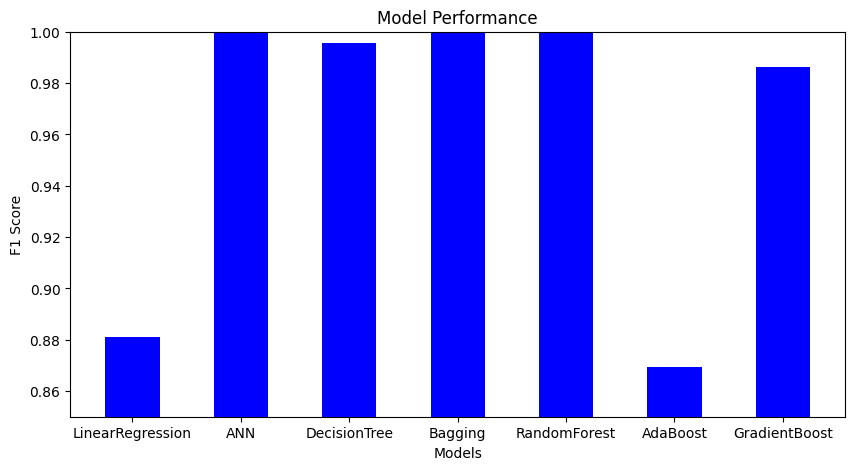

In [238]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(models, F1_scores, color='blue', width=0.5)
ax.set_ylim(0.85, 1.0)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title("Model Performance")

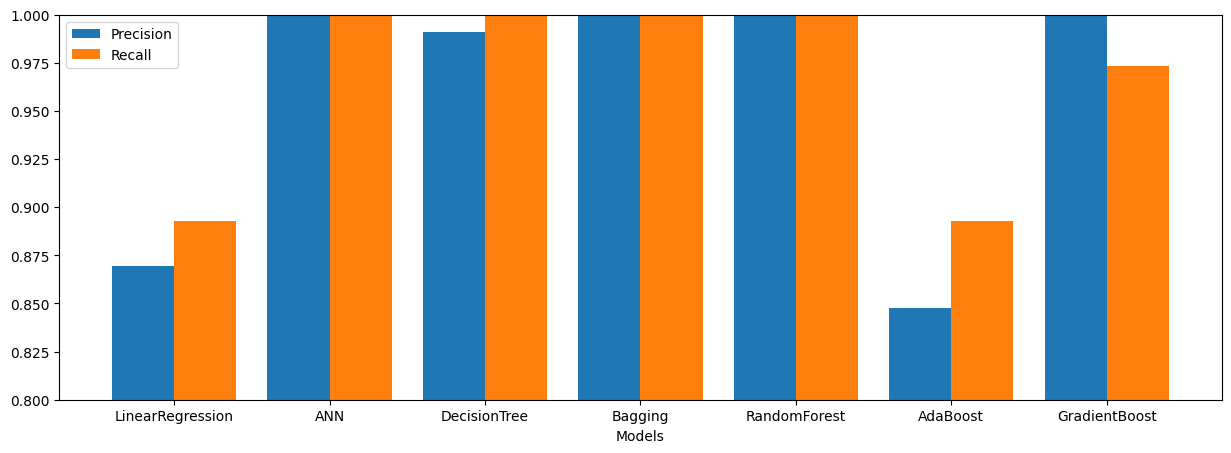

In [239]:
fig2, ax2 = plt.subplots(figsize = (15, 5))
X_axis = np.arange(len(models))
ax2.bar(X_axis - 0.2, precision_values, 0.4, label = 'Precision') 
ax2.bar(X_axis + 0.2, recall_values, 0.4, label = 'Recall') 
ax2.set_ylim(0.80, 1.0)

plt.xticks(X_axis, models)
plt.xlabel("Models")
plt.legend()